In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import warnings
import sys
sys.path.append('../scripts')
from prediction import *
warnings.filterwarnings('ignore')

In [3]:
store_path = '../datasets/store.csv'
train_path = '../datasets/train.csv'
test_path = '../datasets/test.csv'

# Load datasets
train = pd.read_csv(train_path)
test = pd.read_csv(test_path)
store = pd.read_csv(store_path)

# Merge store information into train and test
train_df = train.merge(store, on='Store', how='left')
test_df = test.merge(store, on='Store', how='left')

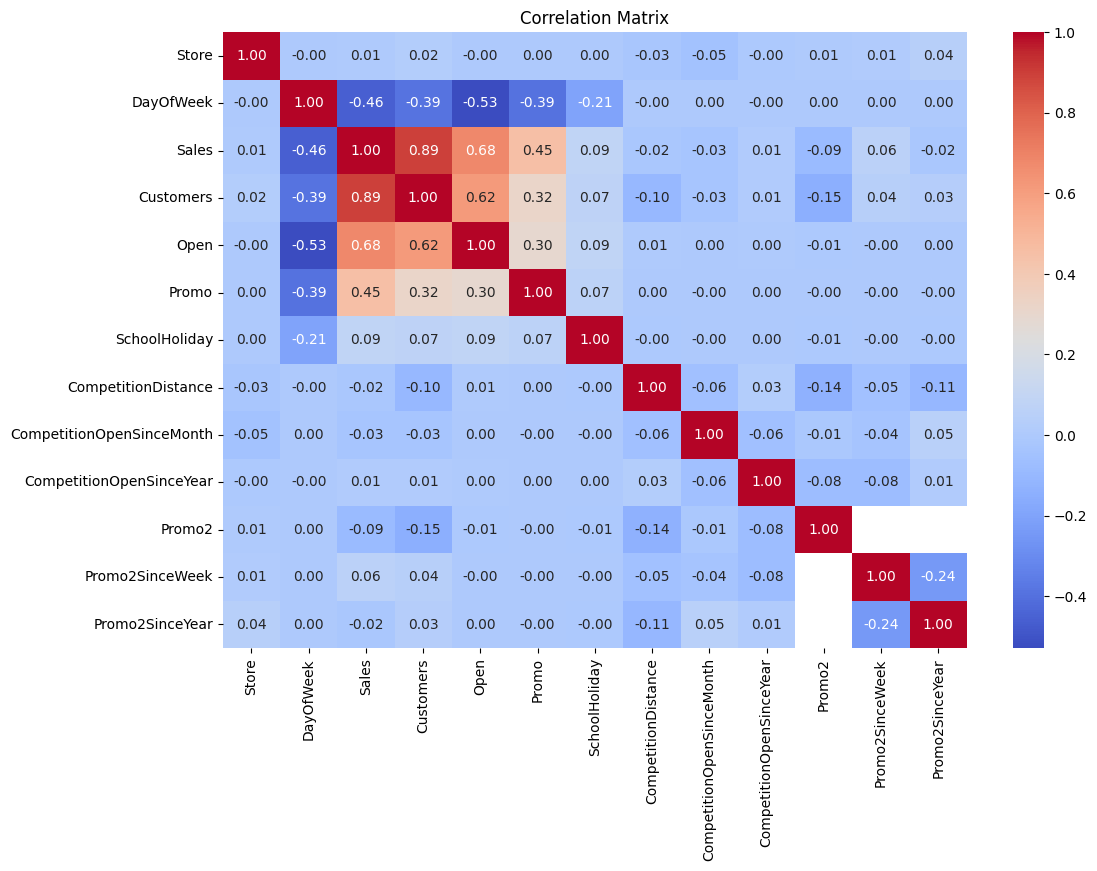

In [4]:
# Calculate correlation matrix
correlation_matrix = train_df.drop(['Date', 'PromoInterval', 'StoreType', 'Assortment', 'StateHoliday'], axis=1).corr()

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title('Correlation Matrix')
plt.show()

In [5]:
# Handle missing values
# CompetitionDistance
train_df['CompetitionDistance'].fillna(train_df['CompetitionDistance'].mean(), inplace=True)
test_df['CompetitionDistance'].fillna(test_df['CompetitionDistance'].mean(), inplace=True)
# CompetitionOpenSinceMonth
train_df['CompetitionOpenSinceMonth'].fillna(-1, inplace=True)
test_df['CompetitionOpenSinceMonth'].fillna(-1, inplace=True)
# CompetitionOpenSinceYear
train_df['CompetitionOpenSinceYear'].fillna(-1, inplace=True)
test_df['CompetitionOpenSinceYear'].fillna(-1, inplace=True)
# Promo2SinceWeek
train_df['Promo2SinceWeek'].fillna(-1, inplace=True)
test_df['Promo2SinceWeek'].fillna(-1, inplace=True)
# Promo2SinceYear
train_df['Promo2SinceYear'].fillna(-1, inplace=True)
test_df['Promo2SinceYear'].fillna(-1, inplace=True)
# PromoInterval
train_df['PromoInterval'].fillna('Missing', inplace=True)
test_df['PromoInterval'].fillna('Missing', inplace=True)

In [6]:
features = ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo',
       'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

X_train = train_df[features]
y_train = train_df['Sales']  # Target variable

In [7]:
X_train.head()

,Store,DayOfWeek,Customers,Open,Promo,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,555,1,1,1,c,a,1270.0,9.0,0,-1.0,-1.0,Missing
1,2,5,625,1,1,1,a,a,570.0,11.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,821,1,1,1,a,a,14130.0,12.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,1498,1,1,1,c,c,620.0,9.0,0,-1.0,-1.0,Missing
4,5,5,559,1,1,1,a,a,29910.0,4.0,0,-1.0,-1.0,Missing


In [8]:
features = ['Store', 'DayOfWeek', 'Open', 'Promo',
       'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval']

X_test = test_df[features]
X_test['Customers'] = X_train['Customers'].mean()
# Reorder columns in test dataset to match training dataset
X_test = X_test[X_train.columns]

In [9]:
# Splitting the train data for validation
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=41088/439434, random_state=42)

In [10]:
categorical_features = ['StoreType', 'Assortment', 'PromoInterval']
numerical_features = ['Store', 'DayOfWeek', 'Customers', 'Open', 'Promo',
       'SchoolHoliday',
       'CompetitionDistance', 'CompetitionOpenSinceMonth', 'Promo2',
       'Promo2SinceWeek', 'Promo2SinceYear']

# Preprocessing for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')  # Ignore unseen categories in test data

# Combine preprocessing
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ]
)

In [11]:
# Define the pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),  # Preprocess data
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  # Random Forest model
])

# Train the pipeline on the training data
# pipeline.fit(X_train, y_train)

In [12]:
# Train the pipeline on a smaller subset of the data for testing
X_train_sample = X_train.sample(frac=0.1, random_state=42)  # Use 10% of data
y_train_sample = y_train.loc[X_train_sample.index]

# Fit the pipeline on the sampled data
pipeline.fit(X_train_sample, y_train_sample)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['Store', 'DayOfWeek',
                                                   'Customers', 'Open', 'Promo',
                                                   'SchoolHoliday',
                                                   'CompetitionDistance',
                                                   'CompetitionOpenSinceMonth',
                                                   'Promo2', 'Promo2SinceWeek',
                                                   'Promo2SinceYear']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['StoreType', 'Assortment',
                                                   'PromoInterval'])])),
                ('model', RandomForestRegressor(random_state=42))])

In [13]:
# Predicting for the purpose of calculating the loss function
y_predicted = pipeline.predict(X_val)

In [14]:
model = pipeline.named_steps['model']  # Extract the RandomForest model from the pipeline
preprocessor = pipeline.named_steps['preprocessor']  # Preprocessing steps

# Predict on the test set
y_pred = pipeline.predict(X_test)

In [15]:
if 'Store' in X_test.columns:
    predictions_df = pd.DataFrame({'Store': X_test['Store'], 'Predicted Value': y_pred})
else:
    predictions_df = pd.DataFrame({'Predicted Value': y_pred})

# Save the predictions to a CSV file
predictions_df.to_csv('../datasets/predictions.csv', index=False)

In [16]:
# 1. Calculate loss
loss = calculate_loss(y_val, y_predicted)
print(f"Mean Squared Error: {loss}")

Mean Squared Error: 391012.34945701243


In [17]:
# Get the feature names from OneHotEncoder within ColumnTransformer
feature_names = preprocessor.transformers_[1][1].get_feature_names_out(input_features=categorical_features)
# Combine feature names from OneHotEncoder with numerical features
all_feature_names = list(feature_names) + numerical_features

importance_df = feature_importance(model, all_feature_names)
print("Feature Importance:\n", importance_df)

Feature Importance:
                                 importance
StoreType_c                       0.867867
Assortment_c                      0.027814
Open                              0.023254
Assortment_a                      0.017207
StoreType_a                       0.016143
SchoolHoliday                     0.009885
StoreType_b                       0.007150
PromoInterval_Feb,May,Aug,Nov     0.006814
PromoInterval_Mar,Jun,Sept,Dec    0.006486
DayOfWeek                         0.005612
PromoInterval_Missing             0.003201
Promo                             0.001460
CompetitionDistance               0.001291
Assortment_b                      0.001087
Promo2                            0.001069
Store                             0.000809
Customers                         0.000687
CompetitionOpenSinceMonth         0.000650
PromoInterval_Jan,Apr,Jul,Oct     0.000512
Promo2SinceYear                   0.000507
Promo2SinceWeek                   0.000495
StoreType_d                      

In [18]:

# 3. Confidence interval
lower_bound, upper_bound = confidence_interval(y_pred)
print(f"95% Confidence Interval: ({lower_bound}, {upper_bound})")

95% Confidence Interval: (6182.544068461523, 6204.228059481059)


In [19]:

# 4. Serialize the model and scaler
serialize_model(model, preprocessor, filename="random_forest_model", path="../model")

Model and scaler saved as: ../model/random_forest_model-12-01-2025-16-14-03.pkl


In [23]:
import joblib
import pandas as pd

# Load the saved model
model = joblib.load('../model/random_forest_model-12-01-2025-16-14-03.pkl')

# Prepare input data
input_data = {
  "Store": 1,
  "DayOfWeek": 3,
  "Customers": 150,
  "Open": 1,
  "Promo": 0,
  "SchoolHoliday": 1,
  "StoreType": "a",
  "Assortment": "b",
  "CompetitionDistance": 500.0,
  "CompetitionOpenSinceMonth": 1,
  "Promo2": 1,
  "Promo2SinceWeek": 5,
  "Promo2SinceYear": 2021,
  "PromoInterval": "Jan,Feb,Mar"
}

# Convert input data to DataFrame
df = pd.DataFrame([input_data])

# Make predictions
prediction = model.predict(df)

# Output the prediction
print("Prediction:", prediction)

AttributeError: 'dict' object has no attribute 'predict'